# Fibroblast analysis - demo

In this notebook I perform primary analysis of liver fibroblast population using tools written in R. I am using single-cell publicly available data to find patterns and differences between fibroblast subsets.

### Importing packages

In [1]:
library(ggplot2) 
library(dplyr)
library(tidyr)
library(pheatmap)
library(purrr)
library(tibble)
library(BiocParallel)
register(MulticoreParam(16)) 

# sc specific
library(Seurat) # importing & manipulating objects
library(monocle3) # pseudotime analysis
library(SingleCellExperiment) # another type of useful object
library(DESeq2) # pseudobulk analysis (comparing clusters)
library(SeuratWrappers) # changing object types
library(patchwork) # plotting objects side by side
library(DEGreport) #  ready-to-share figures of differential expression analyses of count data


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“package ‘Seurat’ was built under R version 4.3.3”
Loading required package: SeuratObject

Warning message:
“package ‘SeuratObject’ was built under R version 4.3.3”
Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t


Warning message:
“package ‘monocle3’ was built under R version 4.3.2”
Loading required package: Biobase

Warning message:
“package ‘Biobase’ was built under R version 4.3.3”
Loading required package: BiocGenerics

Warning message:
“package ‘BiocGenerics’ was built under R version 4.3.2”

Attaching package: ‘BiocGenerics’


The following object is masked from ‘package:SeuratObject’:

    intersect


The following objects are masked from ‘package:dplyr’:

    combine, inter

### Data prep

In [3]:
# import annotated seurat obj (after normalization, scaling etc.)
seurat_obj <- readRDS("../intermediate/mouse/mouse.rds")

In [4]:
# subset only liver cells
seurat_liver <- subset(seurat_obj, subset = organ == "ML")

In [5]:
seurat_liver <- NormalizeData(seurat_liver)
seurat_liver <- FindVariableFeatures(seurat_liver, nfeatures=500)
seurat_liver <- ScaleData(seurat_liver)
seurat_liver <- RunPCA(seurat_liver, npsc = 50)

Normalizing layer: counts

Finding variable features for layer counts

Centering and scaling data matrix

Warning message:
“Different features in new layer data than already exists for scale.data”
PC_ 1 
Positive:  Rgs5, Nkain2, Fcna, Ecm1, Ntm, Cks2, G0s2, Ifi27l2a, Isg15, Iigp1 
	   Hsd11b1, Zfp804b, Ifit3, Egfem1, Sntg1, Ccl2, Apoc1, Bcr, Gm4951, Cxcl10 
	   Igfbp3, Vcam1, Serpina3g, Cxcl14, 1200007C13Rik, Smc4, Pde4b, Kcnq5, Sectm1a, Ifit1 
Negative:  Clec3b, Gsn, Serpinf1, Ebf1, Igfbp6, S100a6, Fbln1, Cd34, Dpt, Mgp 
	   Tppp3, Nbl1, Mfap5, Pid1, Pcolce2, Mast4, C3, Mfap4, S100a16, Naaladl2 
	   Plpp3, Cd9, Gas6, Dpysl3, Abca8a, Slit3, Ctsh, Fmo2, Scara5, Mgst1 
PC_ 2 
Positive:  Pcp4l1, Ctnna3, Myh11, Dgkb, Sncg, Pln, Cnn1, Kcnab1, Lmod1, Bcam 
	   Nrip2, Rcan2, Cap2, Acta2, Sorbs2, Myl9, Synpo2, Tpm2, Tagln, Ptp4a3 
	   Olfr558, Corin, Actg2, Asb2, Rasl12, Rbpms2, Myom1, Sh3bgr, Lrrtm3, Tesc 
Negative:  Col3a1, Lum, Celf2, Col1a2, Ifi27l2a, Htra3, Cd34, Rnase4, Dpt, Clec3b 
	   

In [6]:
seurat_liver <- RunUMAP(seurat_liver, dims = 1:30)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


12:45:51 UMAP embedding parameters a = 0.9922 b = 1.112

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’

12:45:51 Read 1529 rows and found 30 numeric columns

12:45:51 Using Annoy for neighbor search, n_neighbors = 30

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’

12:45:51 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

12:45:51 Writing NN index file to temp file /tmp/RtmpoQlPiq/file2677b969f6371b

12:45:51 Searching Annoy index using 1 thread, search_k = 3000

12:45:52 Annoy recall = 100%

12:45:53 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

12:45:54 Initializing from normalized Laplacian +

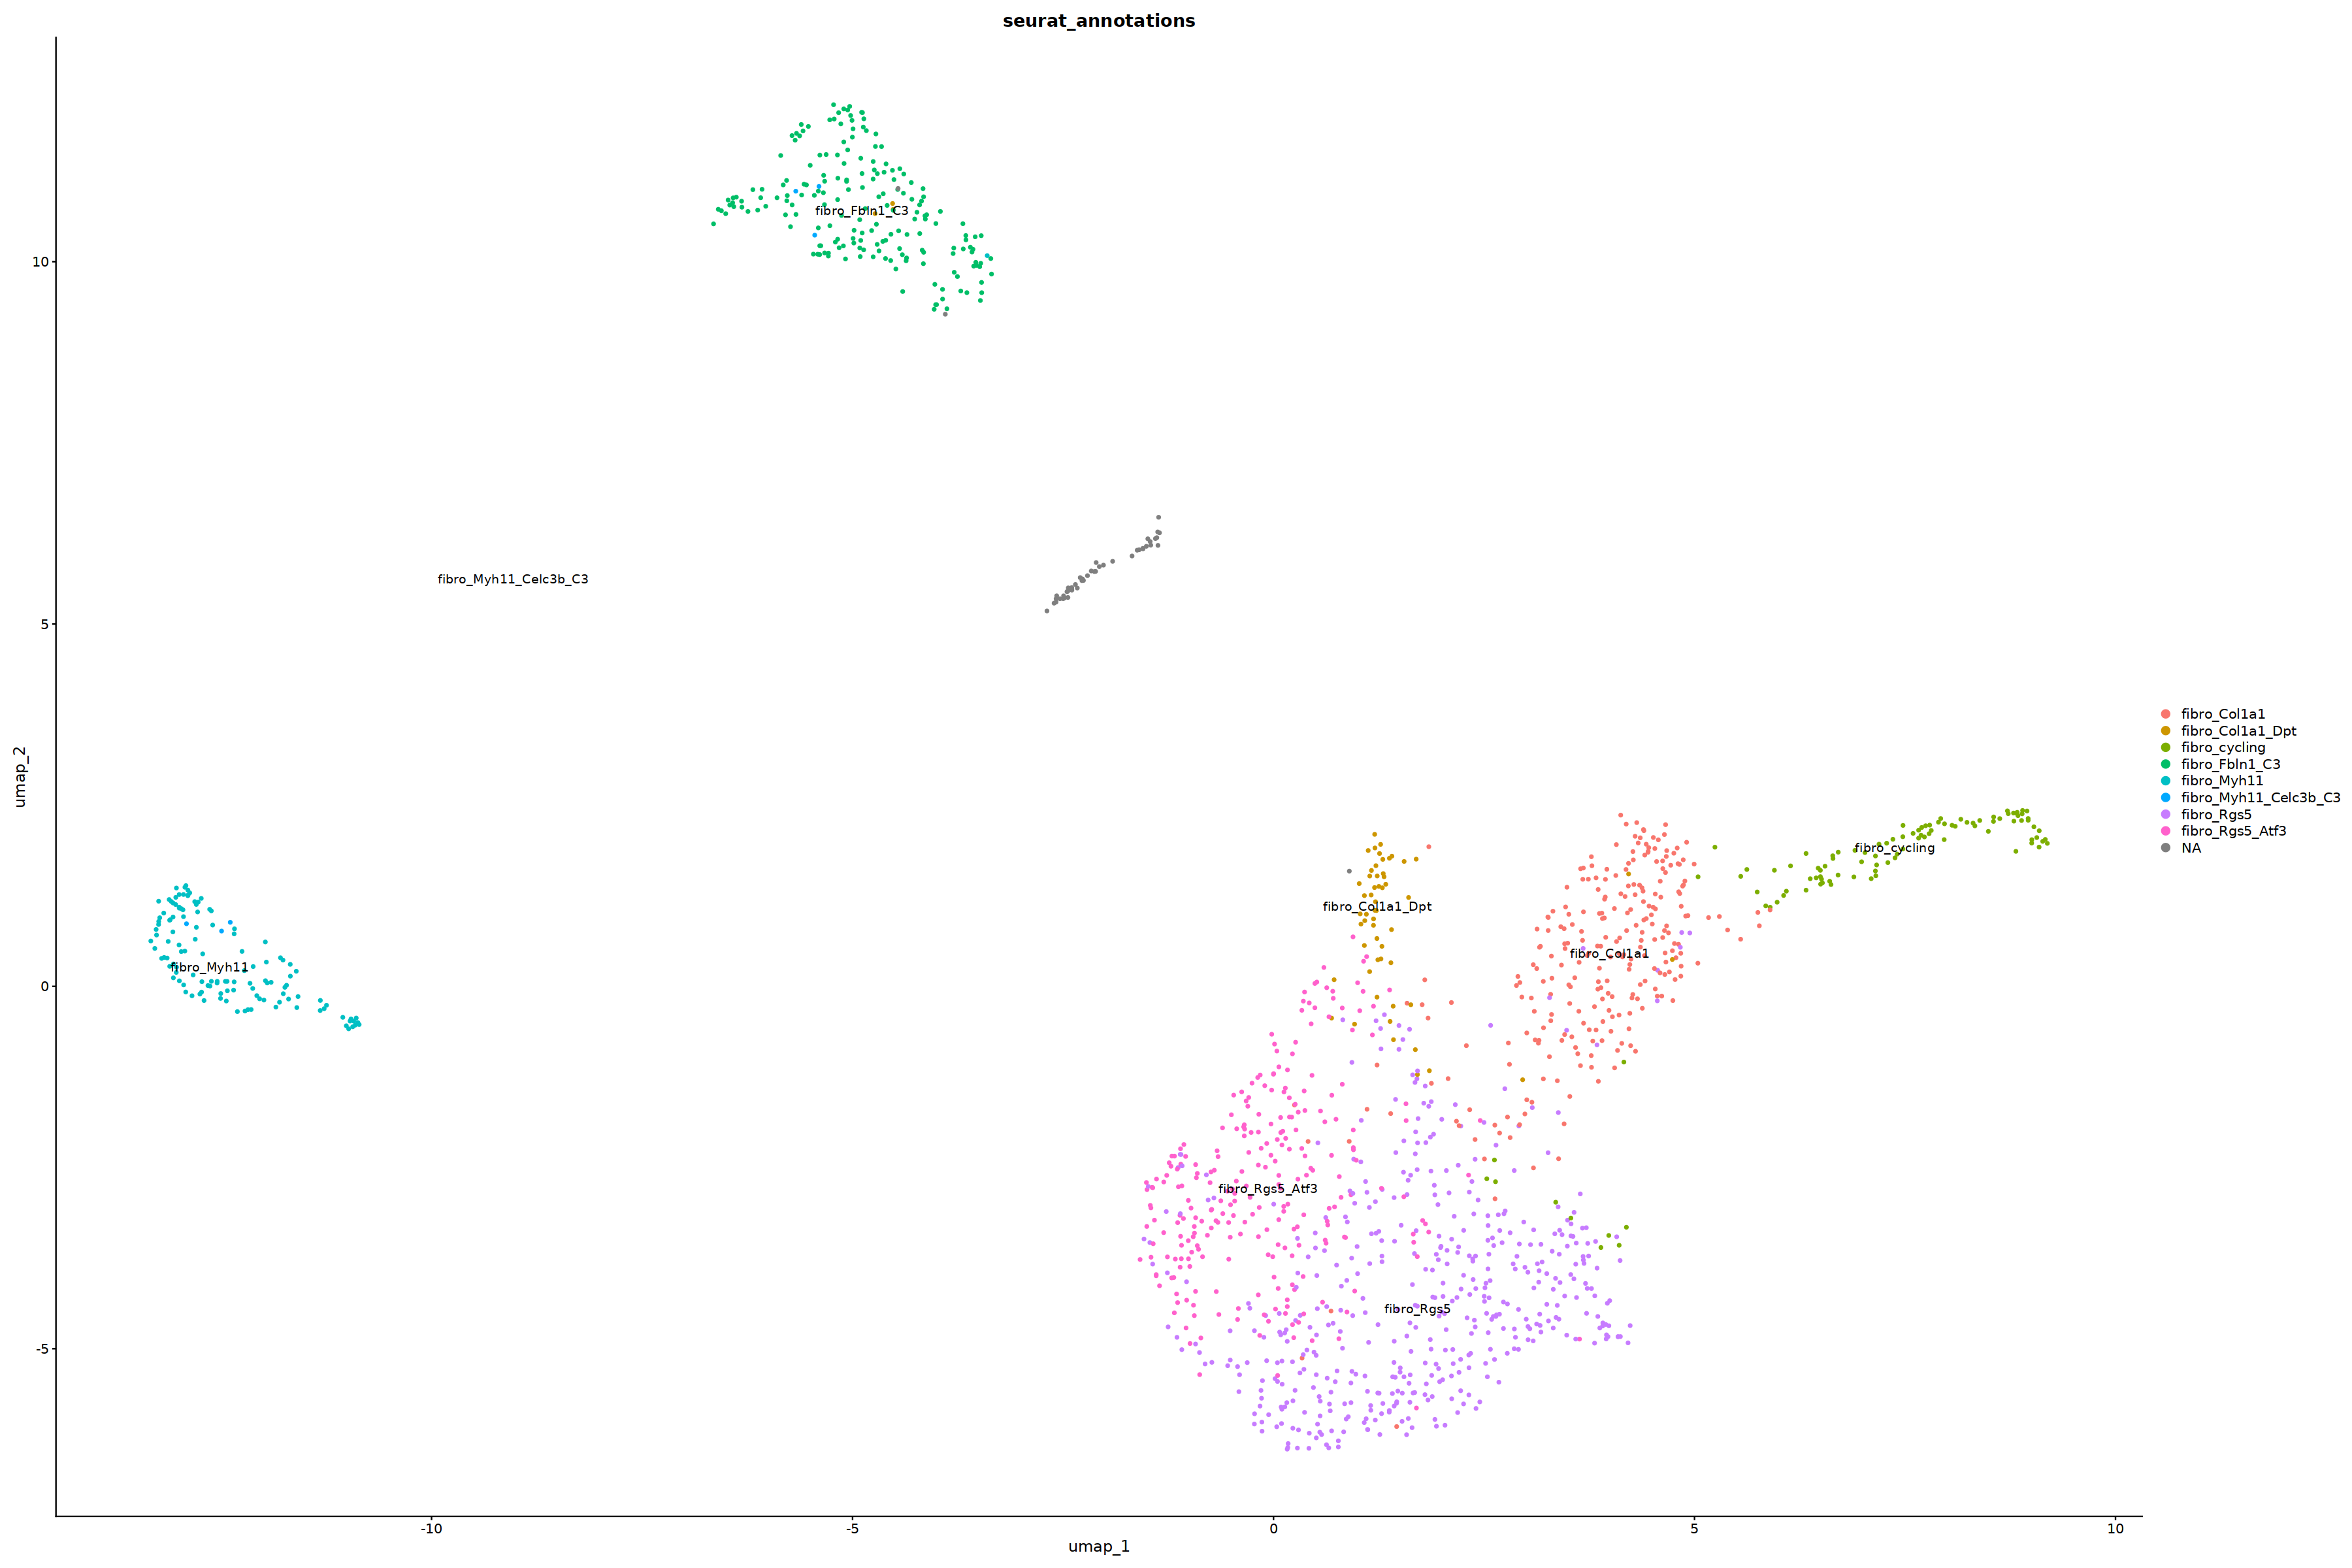

In [7]:
options(repr.plot.width = 30, repr.plot.height = 20)  # larger plot in jupyter notebook
DimPlot(seurat_liver, reduction = "umap", group.by = "seurat_annotations", label=TRUE)

In [8]:
cds_liver <-  as.cell_data_set(seurat_liver)

### Pseudotime

  |======================================================================| 100%
  |======================================================================| 100%


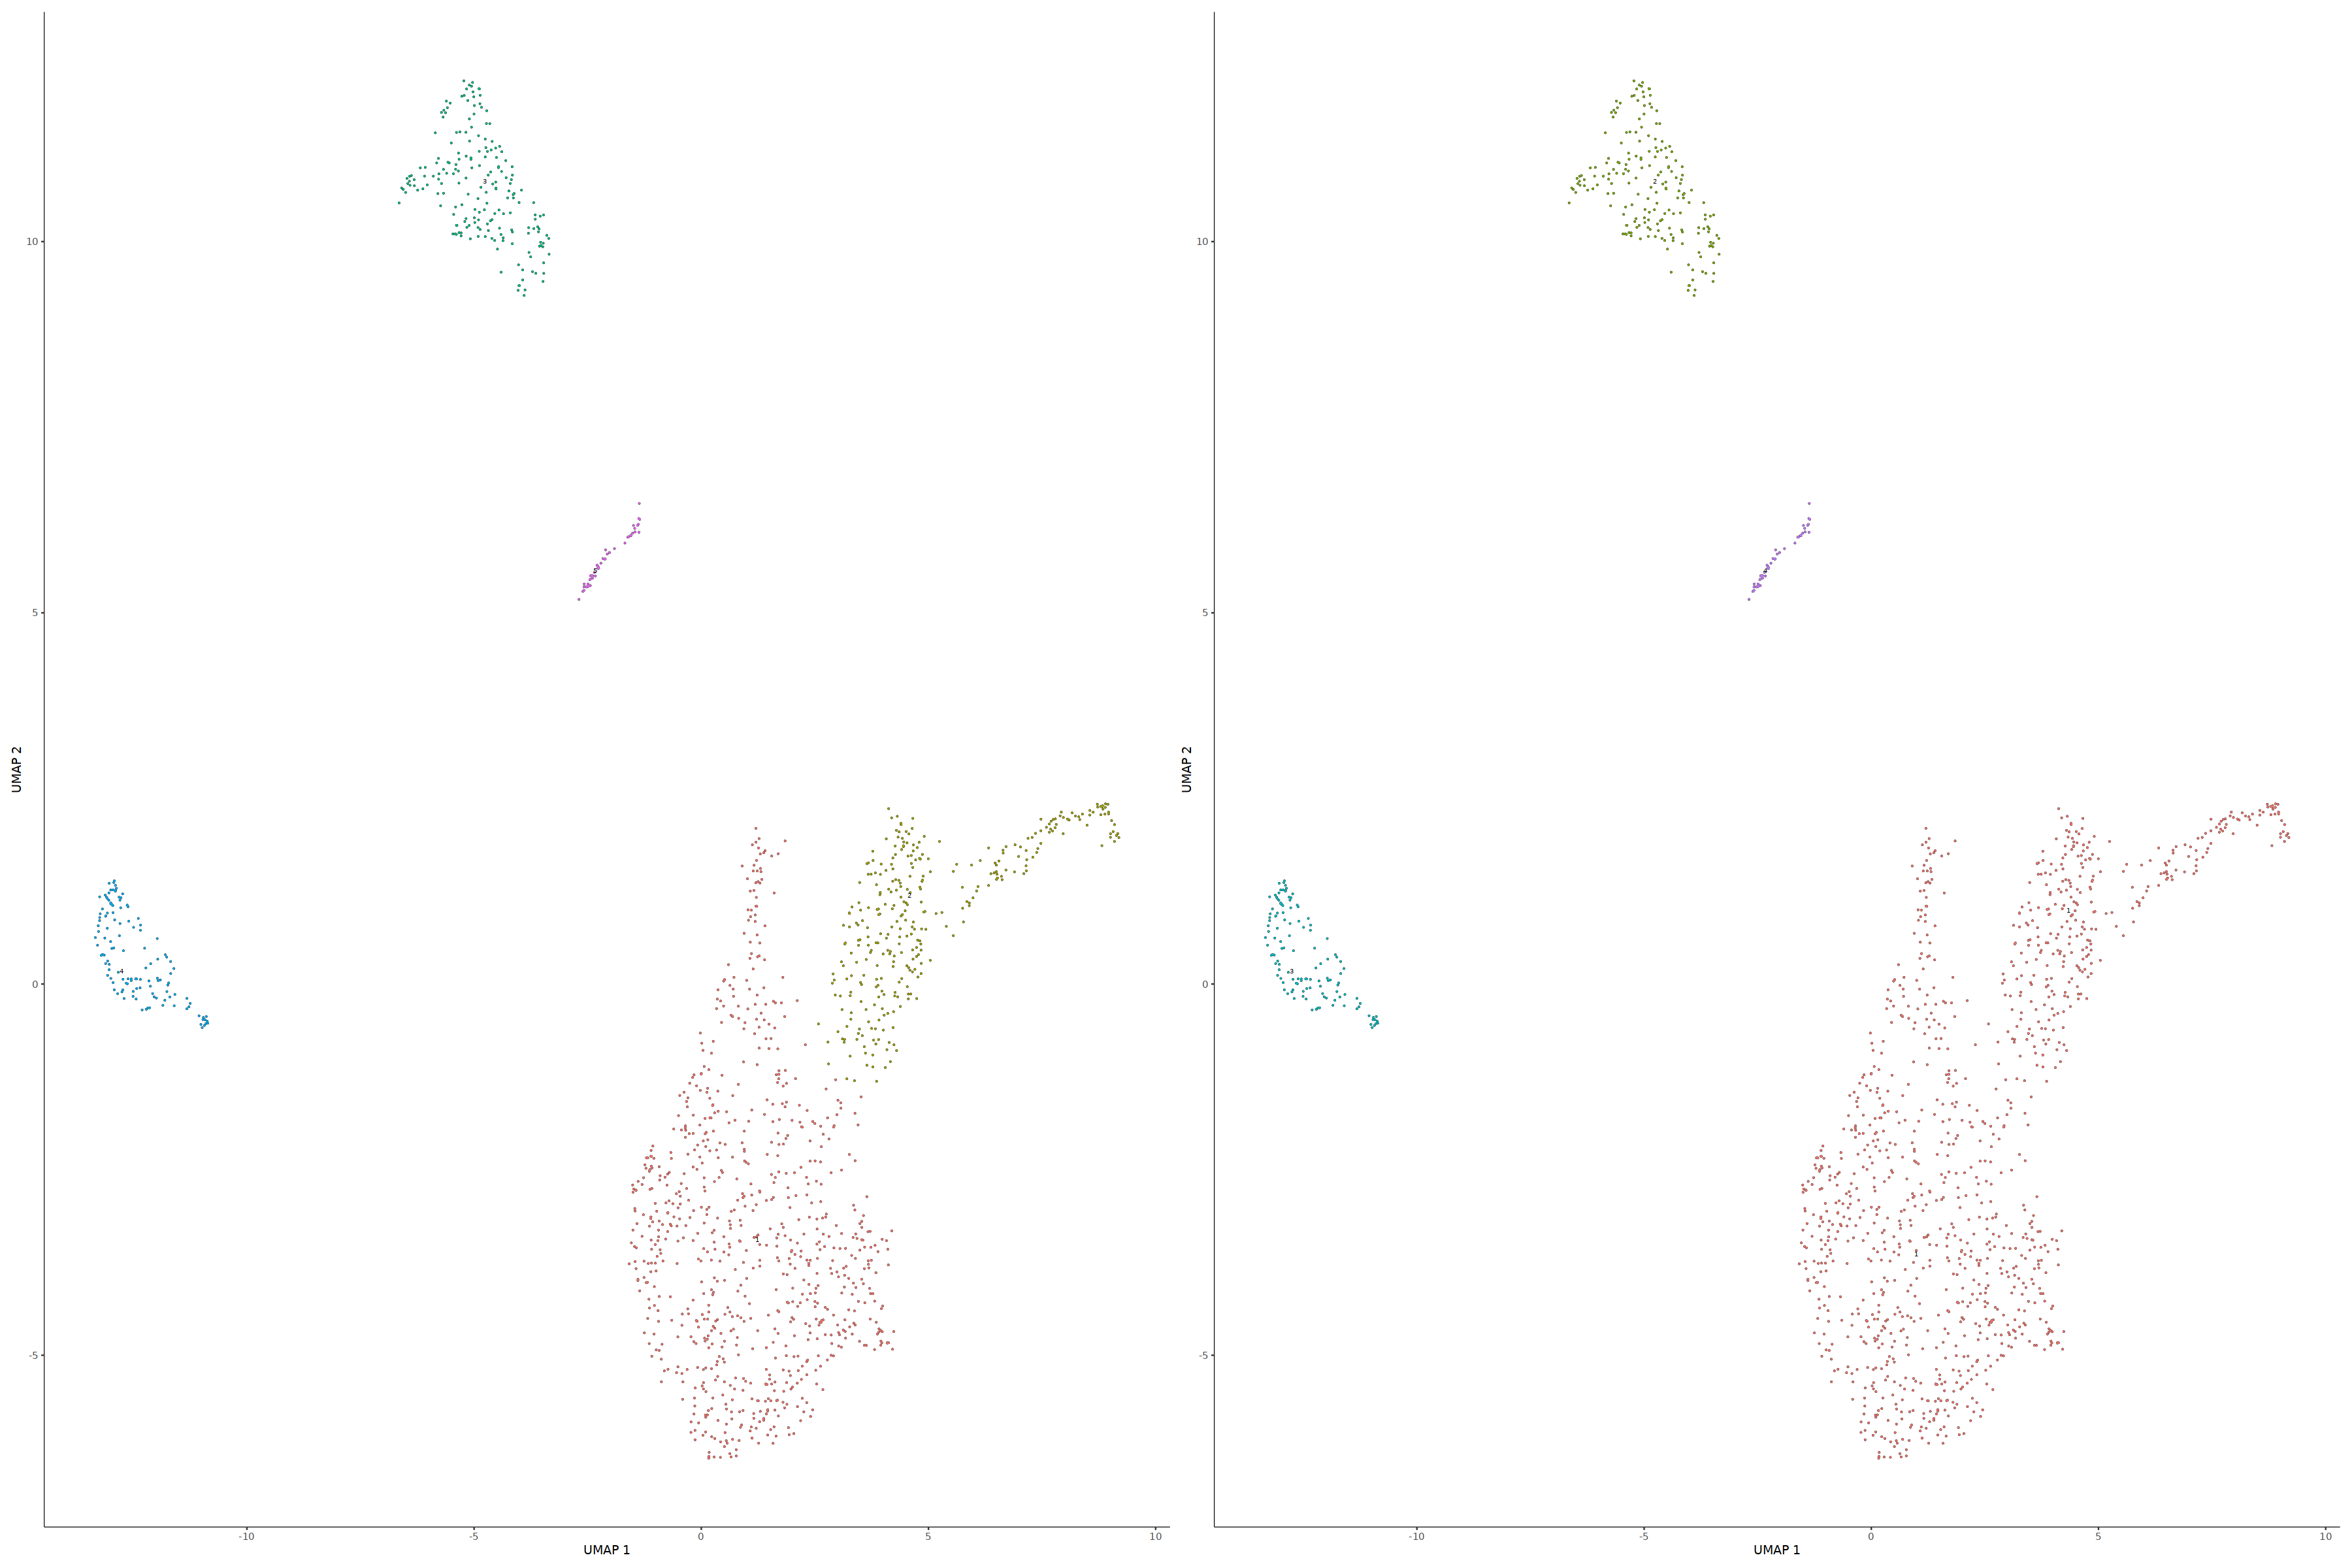

In [10]:
cds_liver <- cluster_cells(cds_liver, resolution=1e-3)
cds_liver <- learn_graph(cds_liver, use_partition = TRUE)

p1 <- plot_cells(cds_liver, color_cells_by = "cluster", show_trajectory_graph = FALSE)
p2 <- plot_cells(cds_liver, color_cells_by = "partition", show_trajectory_graph = FALSE)
wrap_plots(p1, p2)

In [11]:
cds_liver <- order_cells(cds_liver, root_cells = colnames(cds_liver[,clusters(cds_liver) == 4]))

Cells aren't colored in a way that allows them to be grouped.



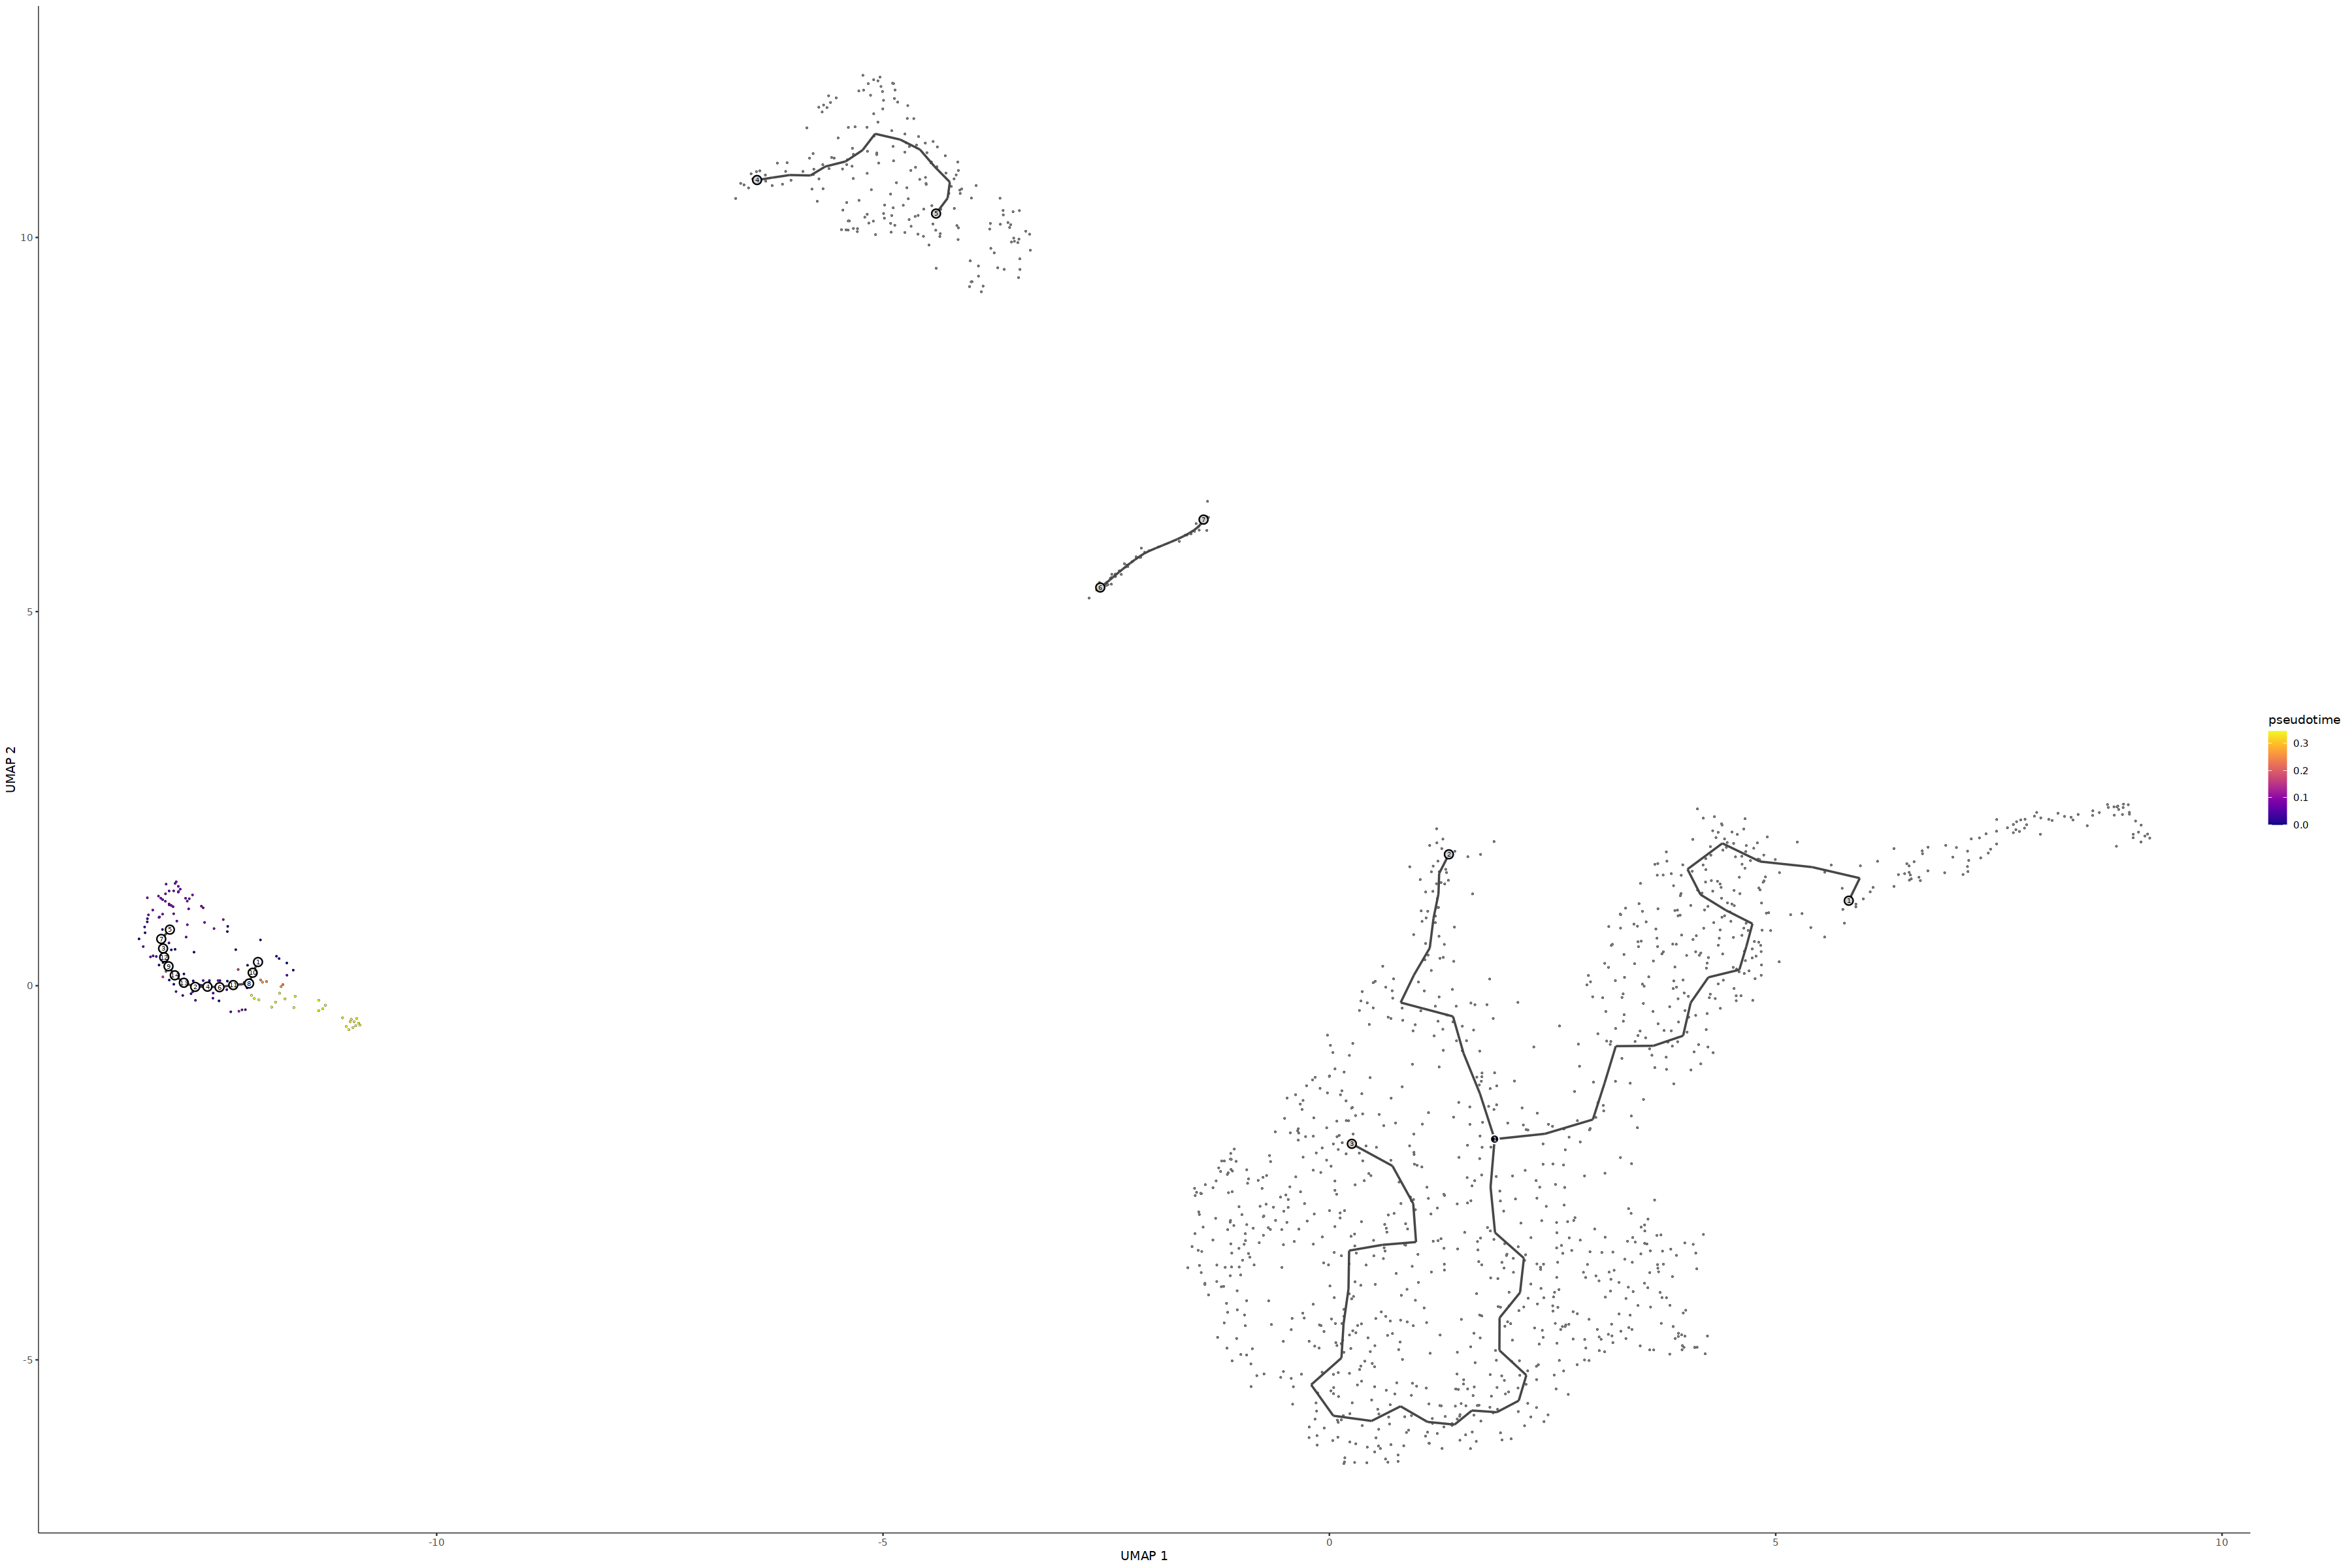

In [12]:
# plot trajectories colored by pseudotime
plot_cells(
  cds = cds_liver,
  color_cells_by = "pseudotime",
  show_trajectory_graph = TRUE
)

### Pseudobulk

In [13]:
counts <- GetAssayData(seurat_liver,slot = 'counts') # raw counts!!
head(counts)

Warning message:
“The `slot` argument of `GetAssayData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.”


  [[ suppressing 1529 column names ‘1_AAAGTAGGTGAGCGAT-1_2_1_1’, ‘1_AAGCCGCGTTCACGGC-1_2_1_1’, ‘1_ACATGGTTCGATCCCT-1_2_1_1’ ... ]]



6 x 1529 sparse Matrix of class "dgCMatrix"
                                                                               
Xkr4    . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Gm1992  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Gm19938 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Gm37381 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Rp1     . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Sox17   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
                                                                               
Xkr4    . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Gm1992  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Gm19938 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Gm37381 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

In [14]:
counts <- counts + 1

In [15]:
metadata <- seurat_liver@meta.data

# Create single cell experiment object
sce <- SingleCellExperiment(assays = list(counts = counts),
                           colData = metadata)

# Identify groups for aggregation of counts
groups <- colData(sce)[, c("seurat_annotations", "status","samples")]

In [16]:
# define groups to compare
sce$group <- paste0(sce$seurat_annotations, "_", sce$samples)

In [17]:
group <- colData(sce)$group

In [18]:
pseudo_bulk_counts <- t(sapply(split(seq_len(ncol(counts)), group),
                               function(indices) rowSums(counts[, indices, drop=FALSE])))
head(pseudo_bulk_counts)

,Xkr4,Gm1992,Gm19938,Gm37381,Rp1,Sox17,Gm37587,Mrpl15,Lypla1,Tcea1,⋯,Olfr316,Vmn1r195,Gm11300,Gm47193,Gm7995,Gm16294,Smok2a,Rhox2h,Magea10,Gm5128
fibro_Col1a1_34_1,33,33,33,33,33,33,33,39,34,40,⋯,33,33,33,33,33,33,33,33,33,33
fibro_Col1a1_34_10,1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1,1,1,1,1,1,1
fibro_Col1a1_34_11,1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1,1,1,1,1,1,1
fibro_Col1a1_34_12,1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1,1,1,1,1,1,1
fibro_Col1a1_34_13,1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1,1,1,1,1,1,1
fibro_Col1a1_34_14,1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1,1,1,1,1,1,1


In [19]:
group_metadata <- data.frame(group = rownames(pseudo_bulk_counts)) %>%
  tidyr::separate(group, into = c("seurat_annotations", "samples"), sep = "_", extra='merge')
head(group_metadata)

,seurat_annotations,samples
,<chr>,<chr>
1,fibro,Col1a1_34_1
2,fibro,Col1a1_34_10
3,fibro,Col1a1_34_11
4,fibro,Col1a1_34_12
5,fibro,Col1a1_34_13
6,fibro,Col1a1_34_14


In [20]:
t_pseudo_bulk_counts <- t(pseudo_bulk_counts)

In [21]:
dds <- DESeqDataSetFromMatrix(countData = t_pseudo_bulk_counts,
                              colData = group_metadata,
                              design = ~ seurat_annotations)

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


In [22]:
dds <- DESeq(dds)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 1 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



In [23]:
res <- results(dds)

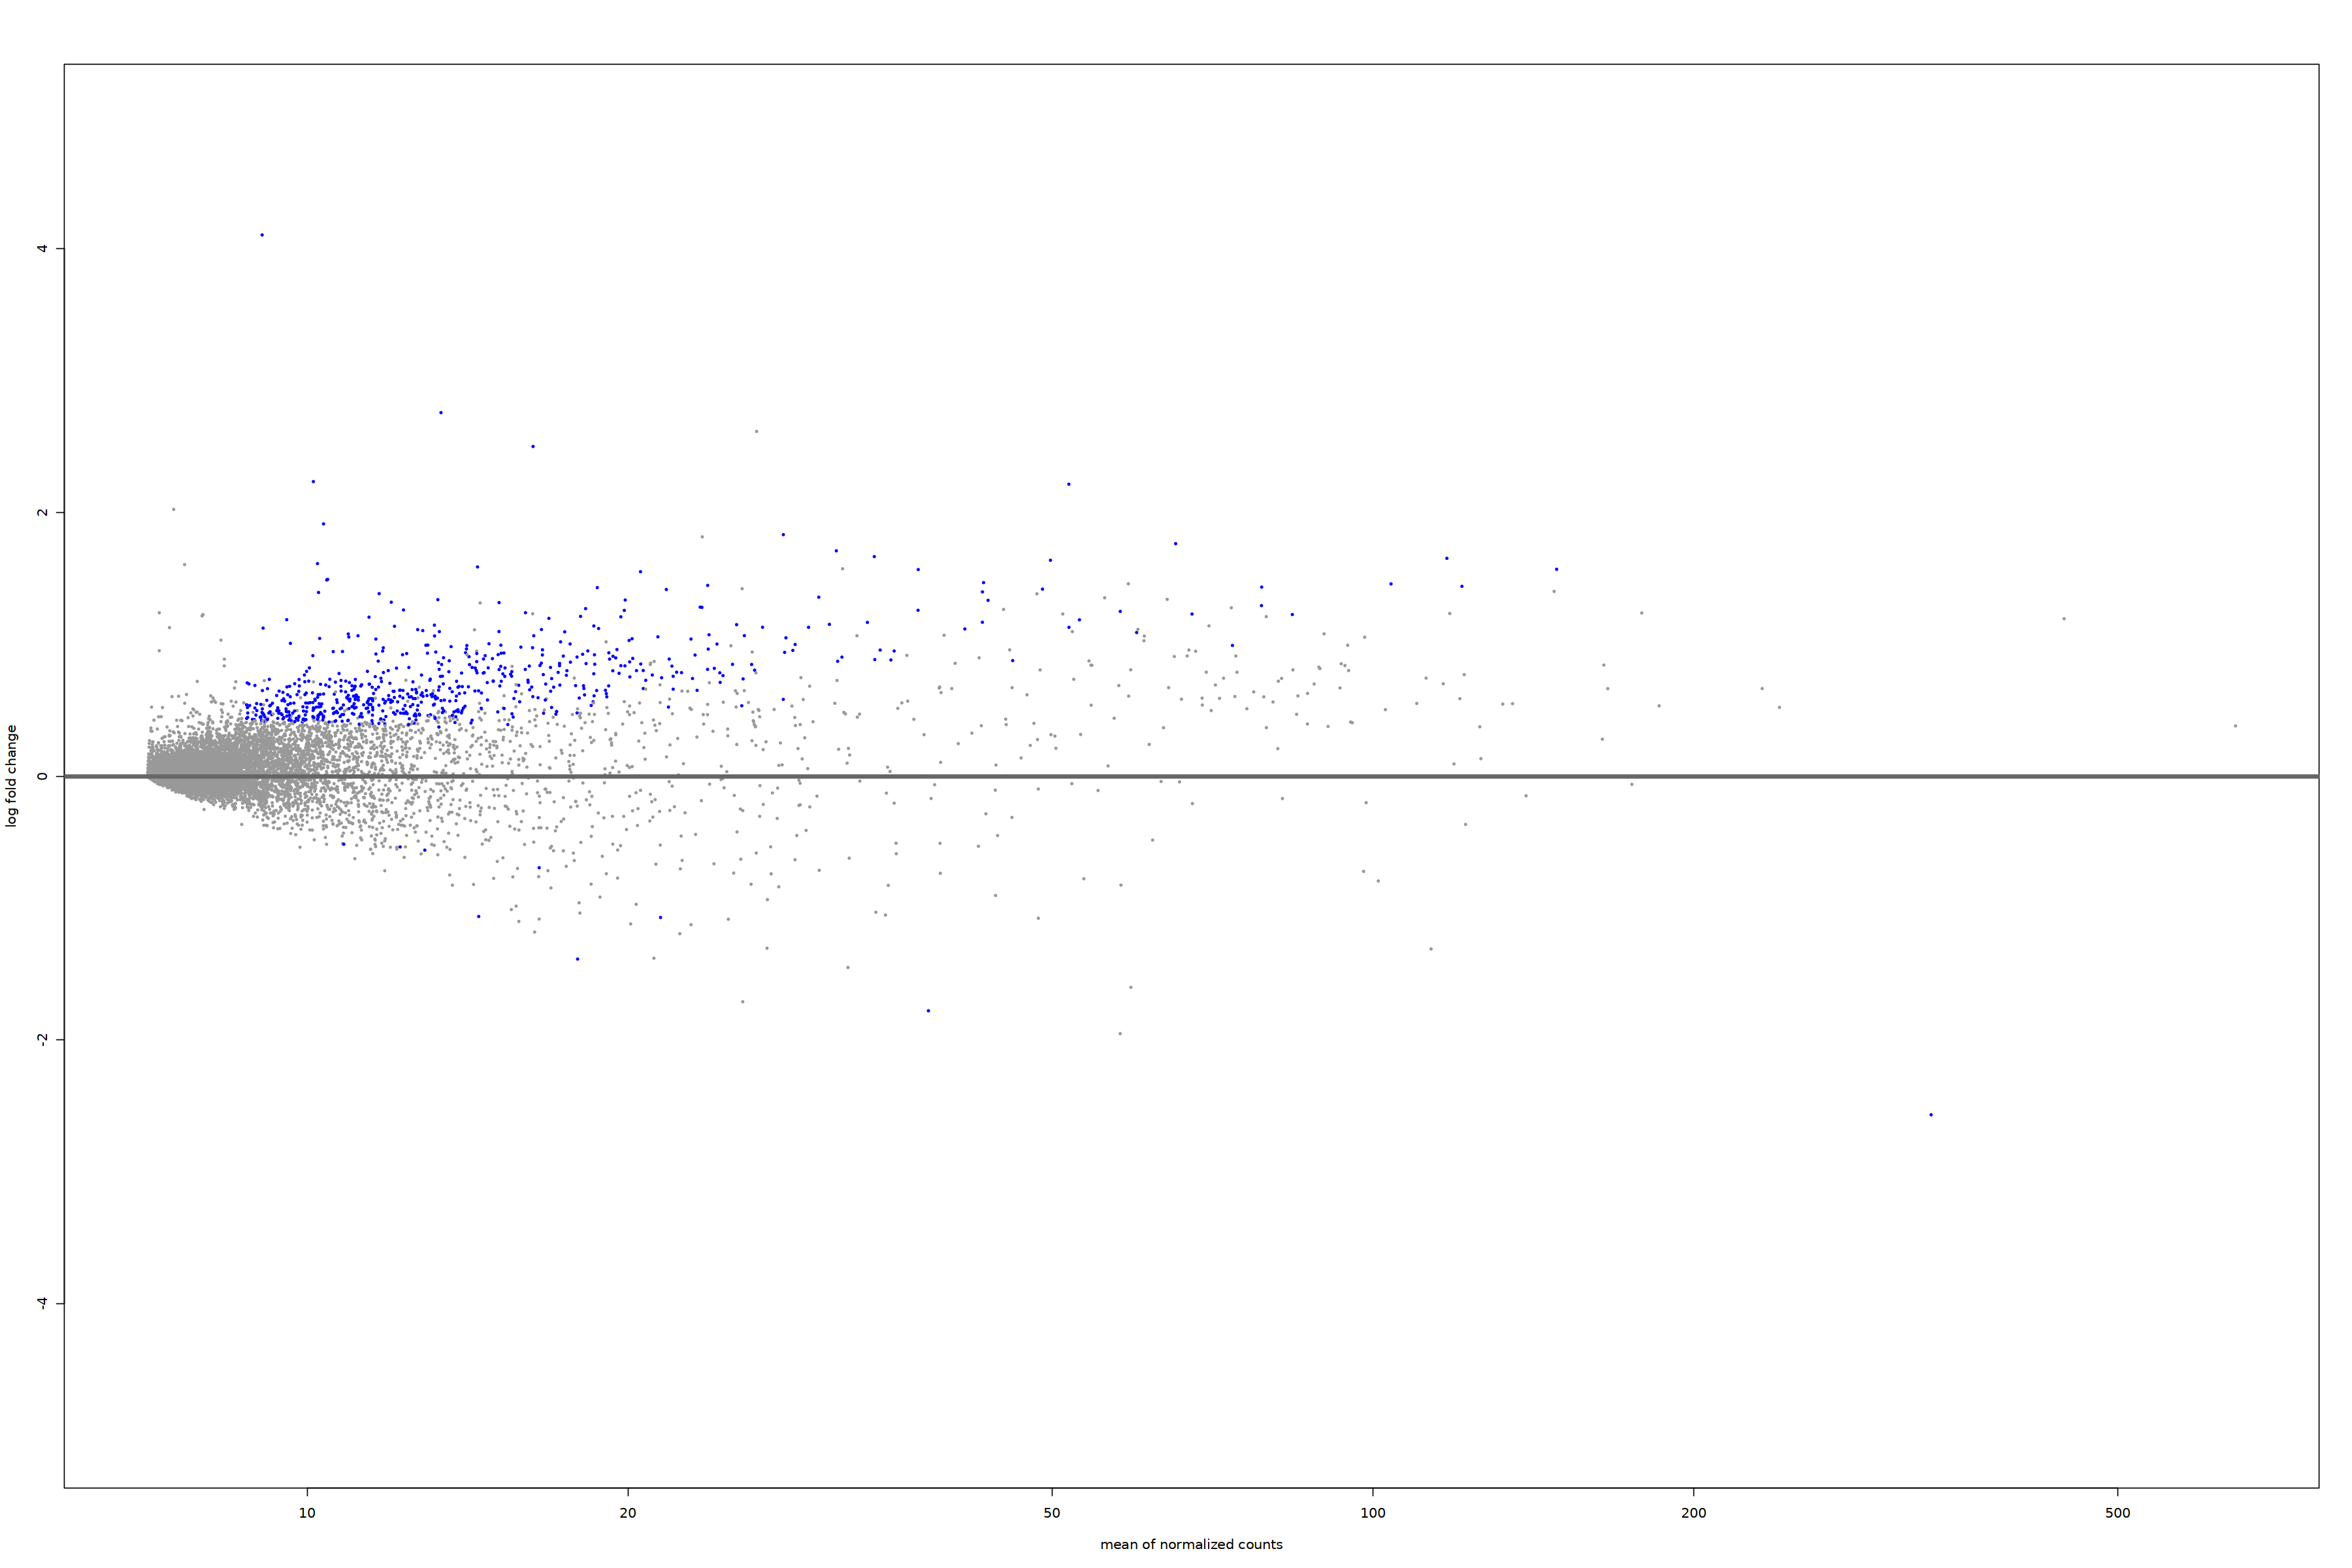

In [24]:
plotMA(res, ylim = c(-5, 5))

In [25]:
top_genes <- rownames(res[order(res$padj), ])[1:30]

In [26]:
normalized_counts <- counts(dds, normalized = TRUE)
top_norm_counts <- normalized_counts[top_genes, ]
head(normalized_counts)

,fibro_Col1a1_34_1,fibro_Col1a1_34_10,fibro_Col1a1_34_11,fibro_Col1a1_34_12,fibro_Col1a1_34_13,fibro_Col1a1_34_14,fibro_Col1a1_34_15,fibro_Col1a1_34_2,fibro_Col1a1_34_3,fibro_Col1a1_34_4,⋯,fibro_Rgs5_Atf3_6_1,fibro_Rgs5_Atf3_6_2,fibro_Rgs5_Atf3_6_3,fibro_Rgs5_Atf3_6_4,fibro_Rgs5_Atf3_6_5,fibro_Rgs5_Atf3_6_6,fibro_Rgs5_Atf3_6_7,fibro_Rgs5_Atf3_6_8,NA_8_1,NA_8_2
Xkr4,7.082934,7.088524,7.091369,7.09111,7.090953,7.08855,7.093655,7.082934,7.085199,7.082934,⋯,7.082934,7.082934,7.082934,7.082934,7.082934,7.082934,7.082934,7.082934,7.345265,7.420216
Gm1992,7.082934,7.088524,7.091369,7.09111,7.090953,7.08855,7.093655,7.082934,7.085199,7.082934,⋯,7.082934,7.082934,7.082934,7.082934,7.082934,7.082934,7.082934,7.082934,7.082934,7.082934
Gm19938,7.082934,7.088524,7.091369,7.09111,7.090953,7.08855,7.093655,7.082934,7.085199,7.082934,⋯,7.082934,7.082934,7.082934,7.082934,7.082934,7.082934,7.082934,7.082934,7.082934,7.082934
Gm37381,7.082934,7.088524,7.091369,7.09111,7.090953,7.08855,7.093655,7.082934,7.085199,7.082934,⋯,7.082934,7.082934,7.082934,7.082934,7.082934,7.082934,7.082934,7.082934,7.345265,7.082934
Rp1,7.082934,7.088524,7.091369,7.09111,7.090953,7.08855,7.093655,7.082934,7.085199,7.082934,⋯,7.082934,7.082934,7.082934,7.082934,7.082934,7.082934,7.082934,7.082934,7.082934,7.082934
Sox17,7.082934,7.088524,7.091369,7.09111,7.090953,7.08855,7.093655,7.082934,7.085199,7.082934,⋯,7.082934,7.082934,7.082934,7.082934,7.082934,7.082934,7.082934,7.082934,7.082934,7.082934


In [27]:
# Extract relevant columns from colData
annotation_col <- as.data.frame(colData(dds)[, c("seurat_annotations", "samples")])

# Ensure row names of annotation_col match column names of top_norm_counts
rownames(annotation_col) <- colnames(top_norm_counts)

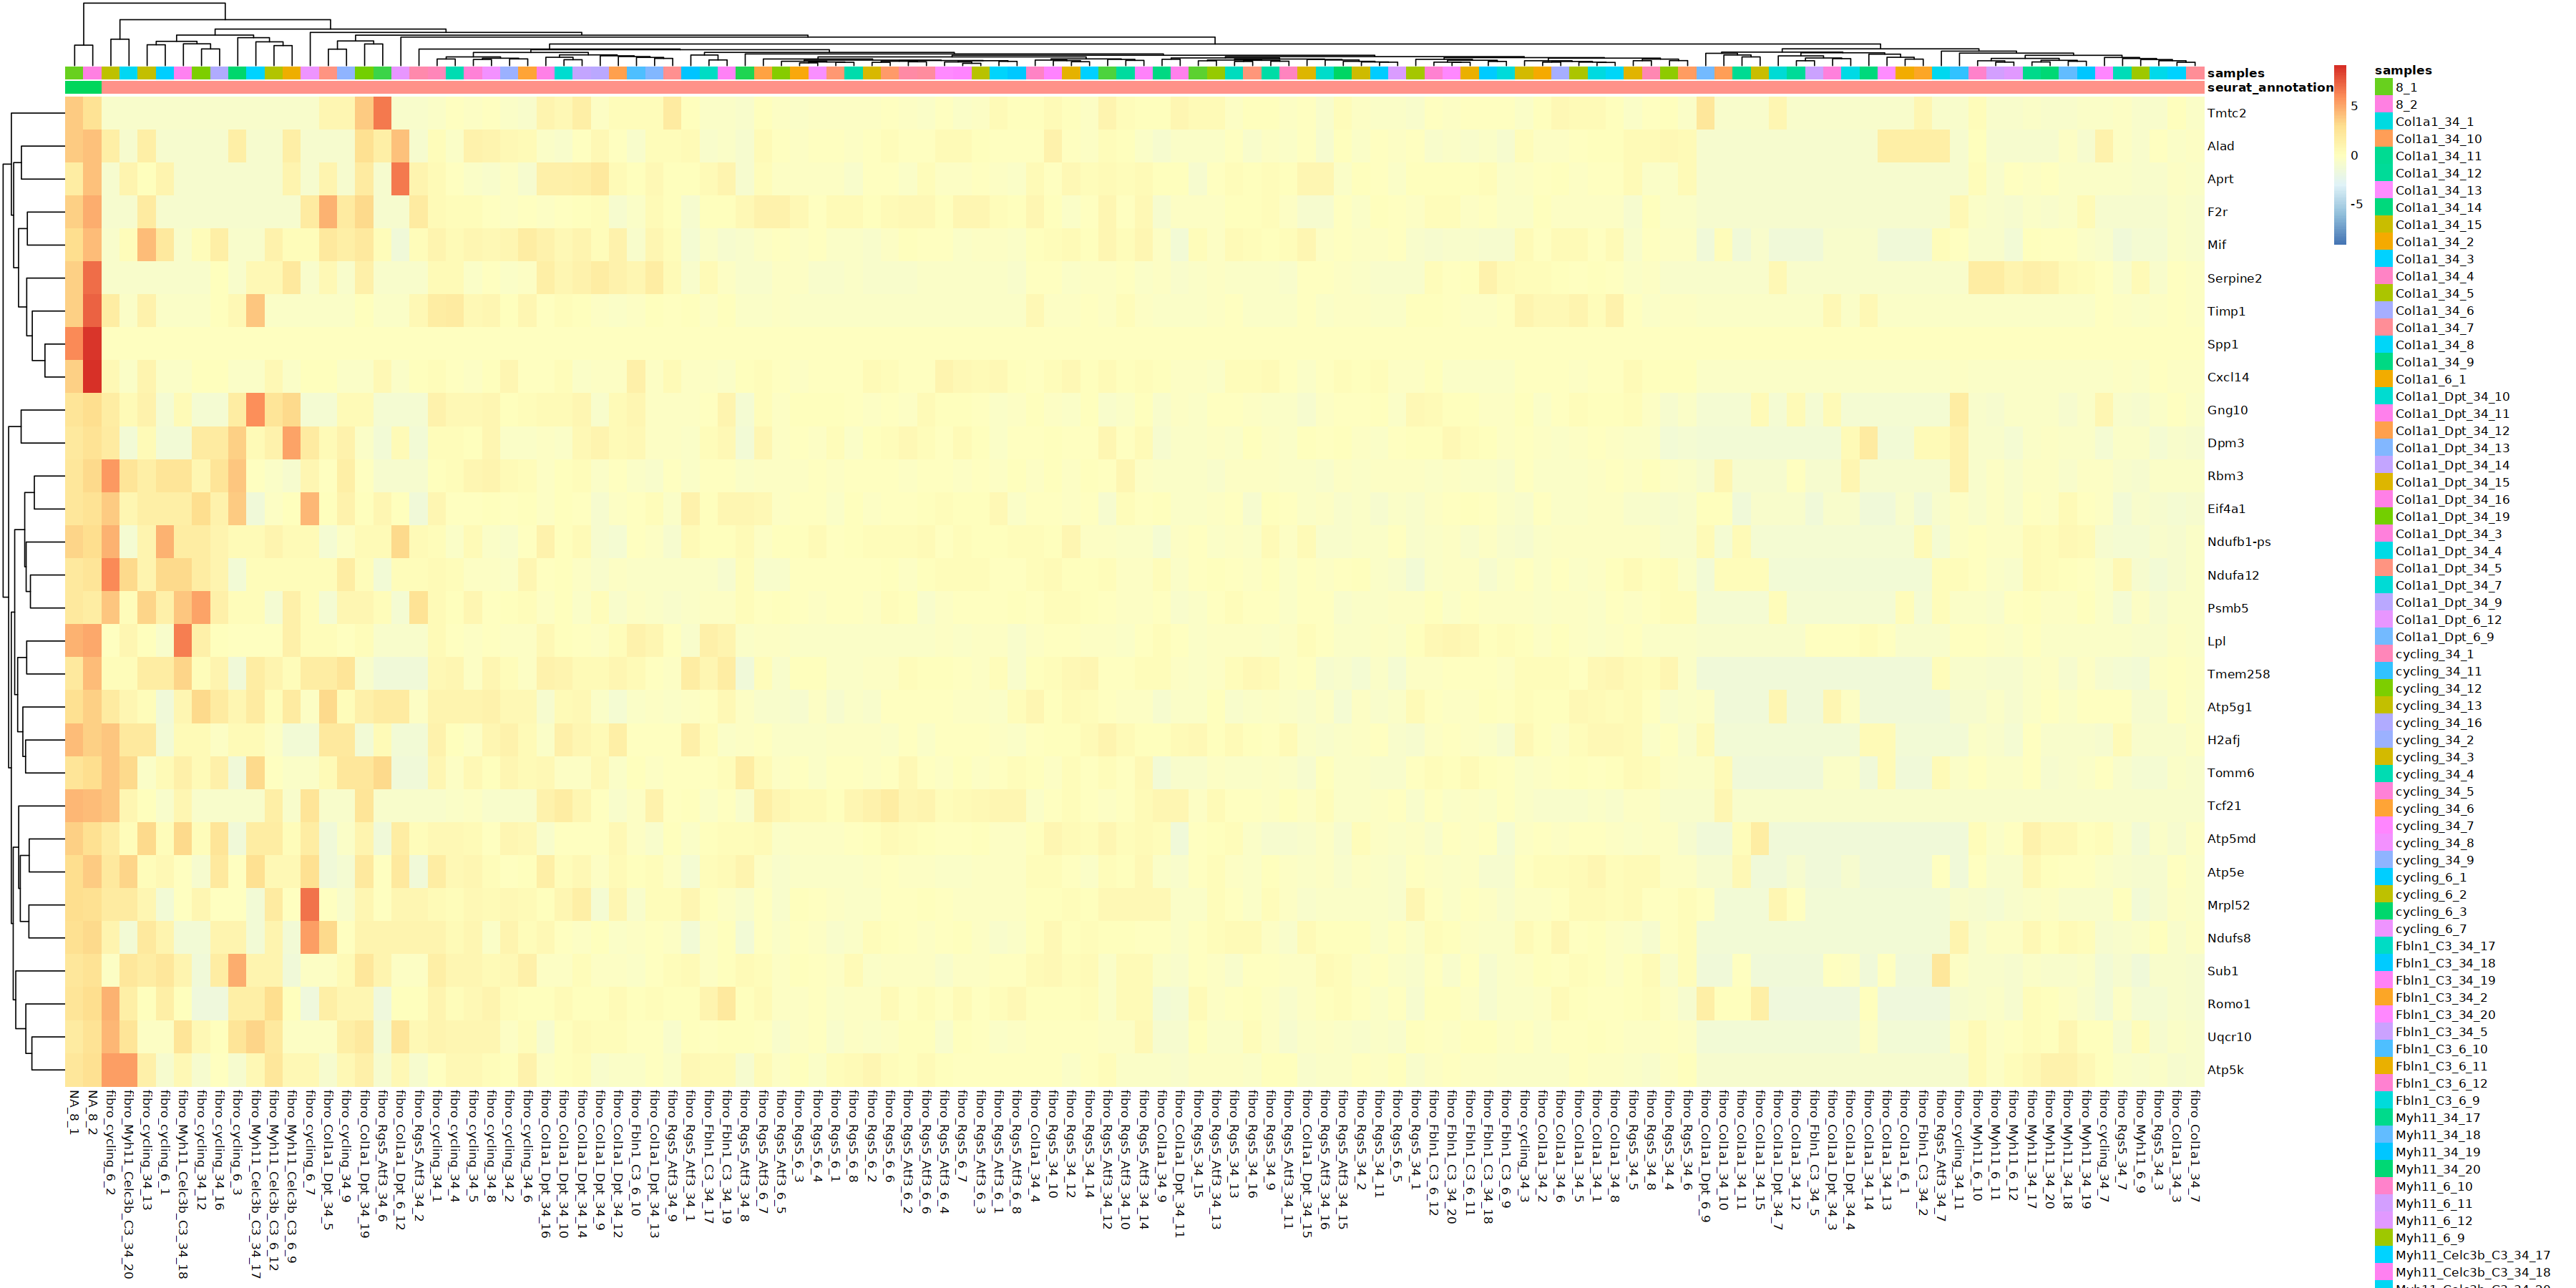

In [28]:
options(repr.plot.width = 30, repr.plot.height = 15)
pheatmap(
  top_norm_counts,
  cluster_rows = TRUE,
  cluster_cols = TRUE,
  scale = "row",          # Standardize by row (genes)
  show_rownames = TRUE,   # Show gene names
  annotation_col = annotation_col   # Add annotation
)

Rgs5+ Mustn1+ Wnt+ has much higher expression of the shown genes. Especially: Clxcl10, Cp, Cxcl2, Ccl2.

In [ ]:
# Get unique cluster names
cluster_names <- unique(seurat_liver@meta.data$seurat_annotations)

# Remove the 9th element as it is NA
cluster_names <- cluster_names[-9]

# Filter cluster names to keep only those with at least 2 unique `group_id` values
filtered_cluster_names <- Filter(function(cluster) {
  subset <- subset(seurat_liver, subset = seurat_annotations == cluster)
  meta <- subset@meta.data
  length(unique(meta$status)) >= 2
}, cluster_names)

# Generate counts_ls for filtered clusters
counts_ls <- lapply(filtered_cluster_names, function(cluster) {
  subset <- subset(seurat_liver, subset = seurat_annotations == cluster)
  GetAssayData(subset, slot = 'counts')
})

names(counts_ls) <- filtered_cluster_names

# Generate metadata_ls for filtered clusters
metadata_ls <- lapply(filtered_cluster_names, function(cluster) {
  subset <- subset(seurat_liver, subset = seurat_annotations == cluster)
  meta <- subset@meta.data
  meta$group_id <- factor(meta$status)
  meta$samples <- factor(meta$samples)
  meta
})

names(metadata_ls) <- filtered_cluster_names

In [31]:
# Create directories to save results if they don't already exist:
if (!dir.exists("DESeq2")) { dir.create("DESeq2") }
if (!dir.exists("DESeq2/lrt")) { dir.create("DESeq2/lrt") }
setwd("DESeq2/lrt/")


# Function to run DESeq2 LRT and get results for any cluster:
## clustx is the name of the cluster (cell type) on which to run the function

## This function assumes the counts matrices and metadata for all clusters have been prepared
## and arranged in matching named lists (as illustrated in tutorial above)
## This function assumes the contrasted groups (e.g. stim A, stim B, control...) are stored in a variable named "group_id"


get_dds_LRTresults <- function(clustx){
  
  print(clustx) # useful for debugging
  
  # Extract counts matrix and metadata for cluster x
  idx <- which(names(counts_ls) == clustx)
  cluster_counts <- counts_ls[[idx]]
  cluster_metadata <- metadata_ls[[idx]]
  
  # Print error message if sample names do not match
  if ( all(colnames(cluster_counts) != rownames(cluster_metadata)) ) {
    print("ERROR: sample names in counts matrix columns and metadata rows do not match!")
  }
  
  # Run DESeq2
  dds <- DESeqDataSetFromMatrix(cluster_counts, 
                                colData = cluster_metadata, 
                                design = ~ group_id)
  dds_lrt <- DESeq(dds, test = "LRT", reduced = ~ 1, parallel = TRUE)
  
  # Extract results
  res_LRT <- results(dds_lrt, parallel = TRUE)
  
  # Create a tibble for LRT results
  res_LRT_tb <- res_LRT %>%
    data.frame() %>%
    rownames_to_column(var = "gene") %>% 
    as_tibble()
  
  # Save all results
  if (!dir.exists("results")) { dir.create("results") }
  write.csv(res_LRT_tb,
            paste0("results/", clustx, "_LRT_all_genes.csv"),
            quote = FALSE, 
            row.names = FALSE)
  
  # Subset to return genes with padj < 0.05
  sigLRT_genes <- res_LRT_tb %>% 
    filter(padj < 0.05)
  
  # Save significant results
  write.csv(sigLRT_genes,
            paste0("results/", clustx, "_LRT_signif_genes.csv"),
            quote = FALSE, 
            row.names = FALSE)
  
  # Transform counts for data visualization
  rld <- rlog(dds_lrt, blind = TRUE)
  
  # Extract the rlog matrix from the object and compute pairwise correlation values
  rld_mat <- assay(rld)
  rld_cor <- cor(rld_mat)
  
  # Obtain rlog values for those significant genes
  cluster_rlog <- rld_mat[sigLRT_genes$gene, ]
  cluster_meta_sig <- cluster_metadata[which(rownames(cluster_metadata) %in% colnames(cluster_rlog)), ]
  
  # Use the `degPatterns` function from DEGreport package to show gene clusters across sample groups
  cluster_groups <- degPatterns(cluster_rlog, metadata = cluster_meta_sig,
                                time = "group_id", col = NULL)
  ggsave(paste0("results/", clustx, "_LRT_DEgene_groups.png"))
  
  # Save what is stored in the `df` component
  write.csv(cluster_groups$df,
            paste0("results/", clustx, "_LRT_DEgene_groups.csv"),
            quote = FALSE, 
            row.names = FALSE)
  
  saveRDS(cluster_groups, paste0("results/", clustx, "_LRT_DEgene_groups.rds"))
  save(dds_lrt, cluster_groups, res_LRT, sigLRT_genes, 
       file = paste0("results/", clustx, "_all_LRTresults.Rdata"))
  
}

In [32]:
map(filtered_cluster_names, get_dds_LRTresults)

[1] "fibro_Col1a1"


converting counts to integer mode

estimating size factors

estimating dispersions

gene-wise dispersion estimates: 16 workers

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

final dispersion estimates, fitting model and testing: 16 workers

-- replacing outliers and refitting for 13196 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing

rlog() may take a long time with 50 or more samples,
vst() is a much faster transformation

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

